In [5]:
from icecream import ic
import re
import json
from collections import OrderedDict

In [16]:
def get_hits(res_file, TOP_N):
    res_1_hits = {}
    with open(res_file) as f:
        lines = f.readlines()
        line_id = 1
        while line_id < len(lines):
            if "Retrieving for" in lines[line_id]:
                bug_id = re.search("report (.+?) \(Its", lines[line_id]).group(1)
                master_id = re.search("Its master is (.+?)\)", lines[line_id]).group(1)
                # ic(bug_id, master_id)
                
                top_n_recommendations = lines[line_id + 1:line_id + TOP_N + 1]
                for index, line in zip(range(TOP_N), top_n_recommendations):
                    if line.strip()[-1] == '+':
                        res_1_hits[bug_id] = index + 1
                        break
                line_id = line_id+TOP_N+1
            else:
                line_id += 1
    return res_1_hits

In [112]:
def get_all_hits(date_project):
    all_hits = set()
    
    for i in range(1, 6):
        hits = set(get_hits(f'../results/recommend_ranknet_{date_project}_gpt_content_r{i}_I-1', 10).keys())
        all_hits |= hits    
    ic(len(all_hits))
    return all_hits


kibana_all_hits = get_all_hits('20240510_kibana')
hadoop_all_hits = get_all_hits('20240510_hadoop')
spark_all_hits = get_all_hits('20240509_spark')

kibana_original_hits = set(get_hits(f'../results/recommend_ranknet_20240509_kibana_replicate_I-1', 10))
hadoop_original_hits = set(get_hits(f'../results/recommend_ranknet_20240509_hadoop_replicate_I-1', 10))
spark_original_hits = set(get_hits(f'../results/recommend_ranknet_20240508_spark_replicate_I-1', 10))

ic(kibana_original_hits - kibana_all_hits)
ic(spark_original_hits - spark_all_hits)

ic| len(all_hits): 123


ic| len(all_hits): 61
ic| len(all_hits): 51
ic| kibana_original_hits - kibana_all_hits: {'66249'}
ic| spark_original_hits - spark_all_hits: {'13300231'}


{'13300231'}

In [101]:
hadoop_all_hits - hadoop_original_hits

{'13281448', '13294199', '13303935', '13304768', '13312586'}

## Draw Venn Diagram

In [86]:
from matplotlib_venn import venn2, venn2_unweighted

def draw_venn_diagram(original_hits, all_hits, project):
    import matplotlib.pyplot as plt
    set1 = set(original_hits)
    set2 = set(all_hits)
    # [set1, set2], 
    venn = venn2_unweighted([set1, set2], set_labels=('CUPID', 'REP'))
    # Set custom colors
    # venn.get_patch_by_id('10').set_radius(1)  # Radius for Set 1
    # venn.get_patch_by_id('01').set_radius(1)  # Radius for Set 2

    venn.get_patch_by_id('10').set_color('#cb4b16')  # Set 1
    venn.get_patch_by_id('01').set_color('#828f2a')  # Set 2
    venn.get_patch_by_id('11').set_color('#decdb0')  # Intersection
    # venn.get_patch_by_id('10').set_color('#8a3324')
    # venn.get_patch_by_id('01').set_color('#8A9A5B')
    # venn.get_patch_by_id('11').set_color('#f5f5dc')

    # Optionally set transparency (alpha)
    for patch_id in ['10', '01', '11']:
        venn.get_patch_by_id(patch_id).set_alpha(0.5)

    for label in venn.set_labels:
        label.set_fontsize(22)  # Set font size here
    # Increase font size of the subset labels (numbers in the circles)
    for label in venn.subset_labels:
        label.set_fontsize(22)  # Set font size here
    # Save the figure
    plt.savefig(f'../fig/venn_{project}.png', dpi=600)
    plt.show()

# draw_venn_diagram(kibana_all_hits, kibana_original_hits, 'kibana')
# draw_venn_diagram(hadoop_all_hits, hadoop_original_hits, 'hadoop')
# draw_venn_diagram(spark_all_hits, spark_original_hits, 'spark')

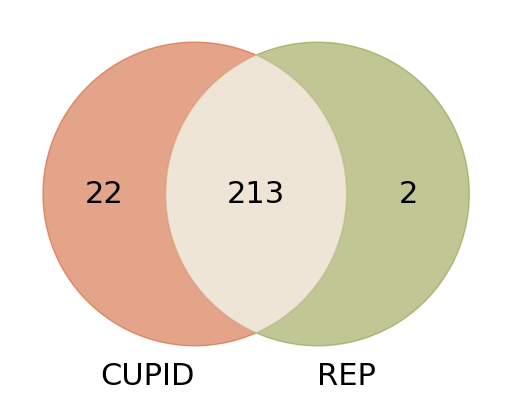

In [87]:
all_hits = kibana_all_hits | hadoop_all_hits | spark_all_hits
original_hits = kibana_original_hits | hadoop_original_hits | spark_original_hits
draw_venn_diagram(all_hits, original_hits, 'all')

In [120]:
import ujson
from icecream import ic
# json_file = '../data/keywords/kibana/kibana_gpt_p1_r1.json'
# json_file = '../data/keywords/hadoop/hadoop_gpt_p1_r3.json'
spark_json_file = '../data/ablation/spark_openchat_content_r1.json'

bug_id = '13278803'
# bug_id = '13276983'

with open(spark_json_file, 'r') as f:
    content_lines = f.readlines()
    
for line in content_lines:
    content = ujson.loads(line)
    if content['bug_id'] == bug_id:
        ic(content['bug_id'])
        ic(content['short_desc'])
        ic(content['description'])
        break

ic| content['bug_id']: '13278803'
ic| content['short_desc']: ('Deadlock between block-manager-slave-async-thread-pool and spark context '
                            'cleaner')
ic| content['description']: ('Deadlock happens while cleaning up the spark context. Here is the full '
                             'thread dump:
                            '
                             '
                            '
                             ' 
                            '
                             ' 2020-01-10T20:13:16.2884057Z Full thread dump Java HotSpot(TM) 64-Bit '
                             'Server VM (25.221-b11 mixed mode):
                            '
                             '2020-01-10T20:13:16.2884392Z 
                            '
                             '2020-01-10T20:13:16.2884660Z "SIGINT handler" #488 daemon prio=9 os_prio=2 '
                             'tid=0x00000000111fa000 nid=0x4794 waiting for monitor entry '
                             '[0x0000

In [116]:
def get_hits_by_bugid(res_file, bug_id_to_check):
    res_1_hits = {}
    
    with open(res_file) as f:
        lines = f.readlines()
        line_id = 1
        while line_id < len(lines):
            if "Retrieving for" in lines[line_id]:
                bug_id = re.search("report (.+?) \(Its", lines[line_id]).group(1)
                if bug_id_to_check != bug_id:
                    line_id += 11
                    continue
                
                master_id = re.search("Its master is (.+?)\)", lines[line_id]).group(1)
                # ic(bug_id, master_id)
                
                top_n_recommendations = lines[line_id + 1:line_id + 10 + 1]
                for index, line in zip(range(10), top_n_recommendations):
                    print(line)
                break
            else:
                line_id += 1
    return res_1_hits
# get_hits_by_bugid(f'../results/recommend_ranknet_20240510_kibana_gpt_content_r1_I-1', '66249')
# for bug_id in {'13281448', '13294199', '13303935', '13304768', '13312586'}:
    # ic(bug_id)
    # print(get_hits_by_bugid(f'../results/recommend_ranknet_20240510_hadoop_gpt_content_r3_I-1', bug_id))
    
# get_hits_by_bugid(f'../results/recommend_ranknet_20240510_hadoop_gpt_content_r3_I-1', '13312586')
# get_hits_by_bugid(f'../results/recommend_ranknet_20240509_hadoop_replicate_I-1', '13312586')
# get_hits_by_bugid(f'../results/recommend_ranknet_20240508_spark_replicate_I-1', '13300231')
get_hits_by_bugid(f'../results/recommend_ranknet_20240509_spark_gpt_content_r1_I-1', '13300231')

 1 - 13276983(real-sim-id=13276983) : 9.853863  

 2 - 13276984(real-sim-id=13276984) : 9.049009  

 3 - 13238437(real-sim-id=13238437) : 8.959380  

 4 - 13288482(real-sim-id=13288482) : 8.623543  

 5 - 13277118(real-sim-id=13277118) : 8.247568  

 6 - 13235081(real-sim-id=13235081) : 7.908872  

 7 - 13251826(real-sim-id=13251826) : 7.767815  

 8 - 13238339(real-sim-id=13238339) : 7.555810  

 9 - 13288073(real-sim-id=13288073) : 7.366383  

10 - 13281890(real-sim-id=13281890) : 7.242157  



{}